## About Dataset
### Introduction:
This dataset contains MRI scans of the brain categorized into four classes of brain tumors: Glioma, Meningioma, Pituitary, and a "No Tumor" class for healthy scans. These MRI images are essential for the development and testing of machine learning models designed to detect and classify brain tumors. The dataset is particularly useful for research in the medical imaging field, particularly in automating tumor detection in MRI images, which is vital for early diagnosis and treatment of brain cancer.
### Dataset Description:
The Brain Tumor MRI Image Dataset is made up of several MRI scan images categorized into the following four classes:
- $Glioma Tumor$: A class representing MRI images with glioma-type tumors, which originate from glial cells in the brain.
- $Meningioma Tumor$: Images featuring meningioma tumors, which form in the meninges, the layers surrounding the brain and spinal cord.
- $Pituitary Tumor$: This class includes images of pituitary tumors, which develop in the pituitary gland, located at the base of the brain.
- $No Tumor$: Healthy brain MRI scans that do not show any signs of tumors.
The dataset has been updated to ensure better image quality, diversity, and to include more representative cases. It is aimed at building robust and accurate models for brain tumor detection, which can be integrated into medical systems to assist healthcare professionals in diagnosing and monitoring patients.
### Data Structure:
The dataset contains MRI images of varying dimensions and resolutions, each labeled according to its class.
Each class (glioma_tumor, meningioma_tumor, pituitary_tumor, and no_tumor) is stored in separate directories for easy access and usage in model training and evaluation.
The updated dataset now includes additional samples to improve model generalization, and all images are in standardized formats (e.g., PNG, JPEG).
Use Case:
This dataset can be used for building and training machine learning models, especially deep learning models such as Convolutional Neural Networks (CNN), to automatically classify brain tumor types. It is also suitable for research in medical image analysis, AI-based diagnosis systems, and any project focused on health-related image classification.

### $Data Card$:
- https://www.kaggle.com/datasets/arifmia/brain-tumor-mri-image-dataset-updated
### $App Link$:
- https://huggingface.co/spaces/kanneboinakumar/Brain_tummer_classification/blob/main/app.py

## 1.load packags

In [71]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score ,precision_score,recall_score

## 2. Data Loading and preprocessing

### 2.1 Calculating mean and Std

In [64]:

# Define transformation pipeline (without normalization for calculation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(20),  # Random rotation
    transforms.ToTensor()  # Convert to tensor (scales to [0,1])
])

# Load the dataset
train_path = "/content/drive/MyDrive/Training"
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Calculate mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

for imgs, _ in train_dataloader:
    batch_size = imgs.size(0)
    imgs = imgs.view(batch_size, imgs.size(1), -1)  # Reshape to [batch_size, channels, pixels]
    mean += imgs.mean(dim=2).sum(dim=0)  # Sum of means per channel
    std += imgs.std(dim=2).sum(dim=0)    # Sum of std dev per channel
    total_images += batch_size

mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.1776, 0.1776, 0.1776])
Std: tensor([0.1735, 0.1735, 0.1735])


### 2.2. Data loading

In [66]:
# Define data transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(20),  # Random rotation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=mean, std=std)])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=mean, std=std)])

tran_path = "/content/drive/MyDrive/Training"
test_path = "/content/drive/MyDrive/Testing"
train_dataset = ImageFolder(root=tran_path, transform=train_transform)
test_dataset = ImageFolder(root=test_path, transform=train_transform)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=10)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=10)

# Get class names (folder names)
class_names = train_dataset.classes
print("Class Labels:", class_names)

Class Labels: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3.Sample images in our dataset

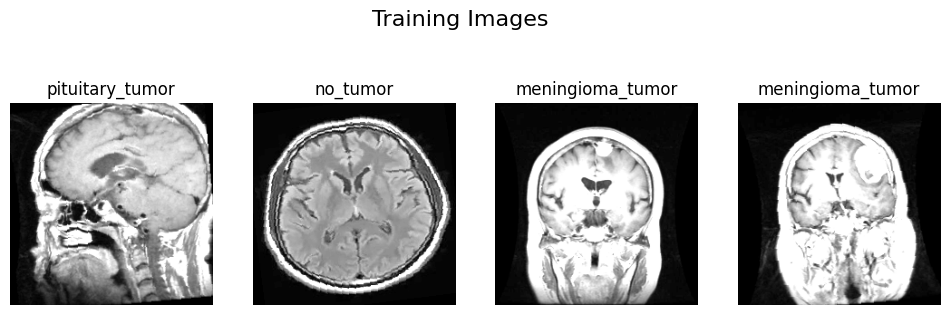

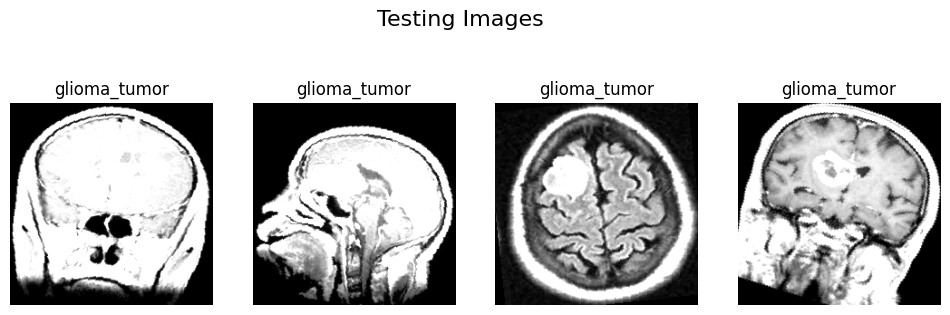

In [67]:
# Function to display images from the dataloader
def display_images(dataloader, num_images=4, title="Sample Images"):
    batch = next(iter(dataloader))
    images, labels = batch
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        image = (image * 0.5) + 0.5
        axes[i].imshow(image)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.show()

# Display some images from the training dataset
display_images(train_dataloader, title="Training Images")

# Display some images from the test dataset
display_images(test_dataloader, title="Testing Images")


## 4.Model Training

### 4.1 Load resnet18 model

In [72]:
resnet18_model = models.resnet18(pretrained=True)
num_of_classes = len(class_names)
num_of_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_of_features, num_of_classes)
# print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model = resnet18_model.to(device)

### 4.2.Define Loss Function & Optimizer

In [81]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.003)

### 4.3.Train the Model

In [69]:
def NeuralNetwork(resnet18_model, train_dataloader, device, loss_fn, optimizer, num_epochs):
    for epoch in range(num_epochs):
        resnet18_model.train()
        running_loss = 0.0
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet18_model(images)
            loss_value = loss_fn(outputs, labels)
            loss_value.backward()
            optimizer.step()
            running_loss += loss_value.item()
        if (epoch +1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")
    return resnet18_model

In [70]:
# Call the function
trained_model = NeuralNetwork(resnet18_model, train_dataloader, device, loss, optimizer, 50)
trained_model

Epoch [10/50], Loss: 0.0440
Epoch [20/50], Loss: 0.0117
Epoch [30/50], Loss: 0.0057
Epoch [40/50], Loss: 0.0091
Epoch [50/50], Loss: 0.0036


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.4. Model Evaluaction

In [73]:
trained_model.eval()
preds = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())

In [74]:
confusion_matrix(test_dataset.targets, preds)

array([[ 26,  45,  26,   3],
       [  0, 114,   1,   0],
       [  0,   0, 105,   0],
       [  0,   3,   8,  63]])

In [10]:
print(classification_report(test_dataset.targets, preds))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39       100
           1       0.68      0.99      0.81       115
           2       0.76      1.00      0.86       105
           3       0.97      0.82      0.89        74

    accuracy                           0.77       394
   macro avg       0.85      0.76      0.74       394
weighted avg       0.84      0.77      0.73       394



In [75]:
print("f1 : ",f1_score(test_dataset.targets, preds, average='macro'))
print("precision_score : ",precision_score(test_dataset.targets, preds, average='macro'))
print("recall_score : ",recall_score(test_dataset.targets, preds, average='macro'))

f1 :  0.748236490745516
precision_score :  0.8520622895622896
recall_score :  0.7756639247943596


## 5.save model

In [76]:
torch.save(trained_model.state_dict(), '/content/drive/MyDrive/Testing/resnet18_model.pth')

## 6.Sample test

## 6.1.load model

In [77]:
model = models.resnet18(pretrained=True)
num_of_classes = len(class_names)
num_of_features = model.fc.in_features
model.fc = nn.Linear(num_of_features, num_of_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/Testing/resnet18_model.pth'))
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-77-a1c7a4684d48>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 6.2. Sample test

In [80]:
sample_img = Image.open("/content/drive/MyDrive/Testing/pituitary_tumor/image(15).jpg")
sample_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.1776, 0.1776, 0.1776], std=[0.1735, 0.1735, 0.1735])])
transformed_img  = sample_transform(sample_img)
pred = model(transformed_img.unsqueeze(0)).max(1)[1].item()
class_names[pred]

'pituitary_tumor'